<a href="https://colab.research.google.com/github/gdelaserre/insee-covid/blob/main/Insee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectifs de l'analyse

Cette analyse visualise les données brutes de surmortalité en France telles que rapportées par l'INSEE depuis Janvier 2020, et les compare aux deux années précédentes afin d'évaluer l'impact net du COVID0-19 en termes de mortalité par tranche d'âge. 


This data analysis investigates excess deaths in France as reported by the INSEE since January of 2020 compared to 2018 and 2019 in an attempt to evaluate the net impact of COVID-19 on overall mortality by age groups. 

#Import files & libraries / Import des fichiers et librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import Markdown as md


age_file = pd.read_csv('/content/drive/MyDrive/Insee/original data/2021-02-05_deces_parsexe_age_jour_France.csv', delimiter = ';')
age_df = pd.DataFrame(age_file)
age_df.head(5)

,Date_evenement,Femmes_0_24ans_Deces2020,Femmes_25_49ans_Deces2020,Femmes_50_64ans_Deces2020,Femmes_65_74ans_Deces2020,Femmes_75_84ans_Deces2020,Femmes_85ans_plus_Deces2020,Hommes_0_24ans_Deces2020,Hommes_25_49ans_Deces2020,Hommes_50_64ans_Deces2020,Hommes_65_74ans_Deces2020,Hommes_75_84ans_Deces2020,Hommes_85ans_plus_Deces2020,Femmes_0_24ans_Deces2019,Femmes_25_49ans_Deces2019,Femmes_50_64ans_Deces2019,Femmes_65_74ans_Deces2019,Femmes_75_84ans_Deces2019,Femmes_85ans_plus_Deces2019,Hommes_0_24ans_Deces2019,Hommes_25_49ans_Deces2019,Hommes_50_64ans_Deces2019,Hommes_65_74ans_Deces2019,Hommes_75_84ans_Deces2019,Hommes_85ans_plus_Deces2019,Femmes_0_24ans_Deces2018,Femmes_25_49ans_Deces2018,Femmes_50_64ans_Deces2018,Femmes_65_74ans_Deces2018,Femmes_75_84ans_Deces2018,Femmes_85ans_plus_Deces2018,Hommes_0_24ans_Deces2018,Hommes_25_49ans_Deces2018,Hommes_50_64ans_Deces2018,Hommes_65_74ans_Deces2018,Hommes_75_84ans_Deces2018,Hommes_85ans_plus_Deces2018,Zone,LibelleZone
0,01/01/2020,11,25,77,96,157,624,7,45,125,192,207,334,7,26,65,105,148,541,16,61,104,173,223,347,7,17,83,79,187,652,12,59,135,164,202,405,FE,France
1,02/01/2020,16,46,152,183,328,1217,16,82,241,382,435,697,12,50,131,210,319,1129,24,120,255,345,436,697,10,36,156,173,377,1351,24,117,291,345,445,788,FE,France
2,03/01/2020,24,66,233,295,519,1814,28,128,380,576,630,1051,22,69,198,311,490,1679,36,153,408,528,668,1016,13,58,229,285,567,2028,34,149,420,527,710,1207,FE,France
3,04/01/2020,26,79,298,384,677,2419,39,170,491,759,826,1401,28,87,276,401,653,2246,44,195,541,703,888,1394,18,82,341,397,746,2687,46,194,555,710,944,1641,FE,France
4,05/01/2020,31,108,351,491,816,2977,53,205,610,937,1013,1711,33,111,342,501,809,2837,56,218,687,880,1114,1757,22,93,403,510,934,3362,59,242,700,874,1188,2044,FE,France


# Cleaning the data / Recalibrage de la donnée

In [ ]:
# drop useless columns
age_df = age_df.drop(['Zone', 'LibelleZone'], axis = 1)
# transform sexe_age column into rows
age_df_clean = age_df.melt(id_vars=['Date_evenement'], 
        var_name="sexe_age", 
        value_name="deces")

# transform sexe_age column into multiple values: année, sexe, groupe_age
age_df_clean['annee'] = age_df_clean['sexe_age'].str.strip().str[-4:].astype(int)
age_df_clean['sexe'] = age_df_clean['sexe_age'].str.strip().str[:6]
age_df_clean['groupe_age'] = age_df_clean['sexe_age'].str.strip().str[7:-13]

# regroupement des groupes d'age:
## '0_24' '25_49' '50_64' => 'moins_de_65'
## '65_74' '75_84' => '65_84'

# create a list of our conditions
conditions = [
    (age_df_clean['groupe_age'] == '0_24') | (age_df_clean['groupe_age'] == '25_49') |(age_df_clean['groupe_age'] == '50_64'),
    (age_df_clean['groupe_age'] == '65_74') | (age_df_clean['groupe_age'] == '75_84'),
    (age_df_clean['groupe_age'] == '85ans_p')
    ]

# create a list of the values we want to assign for each condition
values = ['moins_de_65', '65_84', '85_et_plus']

# create a new column and use np.select to assign values to it using our lists as arguments
age_df_clean['age'] = np.select(conditions, values)
age_df_clean['Date_evenement'] = pd.to_datetime(age_df_clean['Date_evenement'],format='%d/%m/%Y')

# clean up flat file and save it
flat_df = age_df_clean.drop(['sexe_age'], axis = 1)
flat_df['jour'] = flat_df.Date_evenement.dt.strftime('%d')
flat_df['mois'] = flat_df.Date_evenement.dt.strftime('%m')
new_index = ['mois', 'jour', 'annee', 'Date_evenement', 'age', 'groupe_age','sexe','deces']
flat_df = flat_df.reindex(columns = new_index)
flat_df.to_csv('/content/drive/MyDrive/Insee2021-02-05_deces_parsexe_age_jour_France_flat.csv')

# transform flat file into pivot table
pivot_df = flat_df.pivot_table(values = 'deces', index = ['mois','jour'], columns = ['annee','sexe','age','groupe_age'], aggfunc = sum)
pivot_df.to_csv('/content/drive/MyDrive/Insee/2021-02-05_deces_parsexe_age_jour_France_pivot.csv')

# simplify pivot
age_pivot = flat_df.pivot_table(values = 'deces', index = ['mois','jour'], columns = ['annee','age'], aggfunc = sum)
age_pivot.head(5)

annee      2018                         ...  2020                       
age       65_84 85_et_plus moins_de_65  ... 65_84 85_et_plus moins_de_65
mois jour                               ...                             
01   01     632       1057         313  ...   652        958         290
     02    1340       2139         634  ...  1328       1914         553
     03    2089       3235         903  ...  2020       2865         859
     04    2797       4328        1236  ...  2646       3820        1103
     05    3506       5406        1519  ...  3257       4688        1358

[5 rows x 9 columns]

In [ ]:
# add average of past 2 years and compare data
ages = ['moins_de_65', '65_84','85_et_plus']

for age in ages: # moyenne 2018- 2019
  age_pivot['avg_2018_19', age] = (age_pivot[2018,age] + age_pivot[2019,age]) / 2

for age in ages: # surplus de mortalité en volume
  age_pivot['surmortalite_total', age] = age_pivot[2020, age] - age_pivot['avg_2018_19', age] 

for age in ages: # surmortalite en %
  age_pivot['surmortalite_croissance', age] = 100 * age_pivot['surmortalite_total', age] / age_pivot['avg_2018_19', age] 

age_pivot.head(5)

annee      2018             ... surmortalite_croissance           
age       65_84 85_et_plus  ...                   65_84 85_et_plus
mois jour                   ...                                   
01   01     632       1057  ...                1.795472  -1.491003
     02    1340       2139  ...                0.226415  -3.455233
     03    2089       3235  ...               -1.125795  -3.372681
     04    2797       4328  ...               -2.756340  -4.116466
     05    3506       5406  ...               -4.346549  -6.240000

[5 rows x 18 columns]

In [ ]:
# select only the data that we want for visualization 

clean_data = age_pivot.drop([2018,2019, 2020], axis = 1)
clean_data = clean_data.reset_index(level=['mois','jour'])
clean_data['Date'] = clean_data['jour'].astype(str)  + "/" + clean_data['mois'].astype(str) + "/2020"
clean_data.set_index('Date', inplace = True)
clean_data.tail(5)

annee      mois jour avg_2018_19  ... surmortalite_croissance                      
age                  moins_de_65  ...             moins_de_65      65_84 85_et_plus
Date                              ...                                              
27/12/2020   12   27     95050.0  ...                0.100999  10.335719  11.209612
28/12/2020   12   28     95332.5  ...                0.100176  10.353271  11.245330
29/12/2020   12   29     95595.0  ...                0.100424  10.382143  11.276176
30/12/2020   12   30     95888.5  ...                0.056837  10.389761  11.298149
31/12/2020   12   31     96166.0  ...                0.050954  10.381858  11.290184

[5 rows x 11 columns]

# Visualize the Data / Visualisation de la donnée

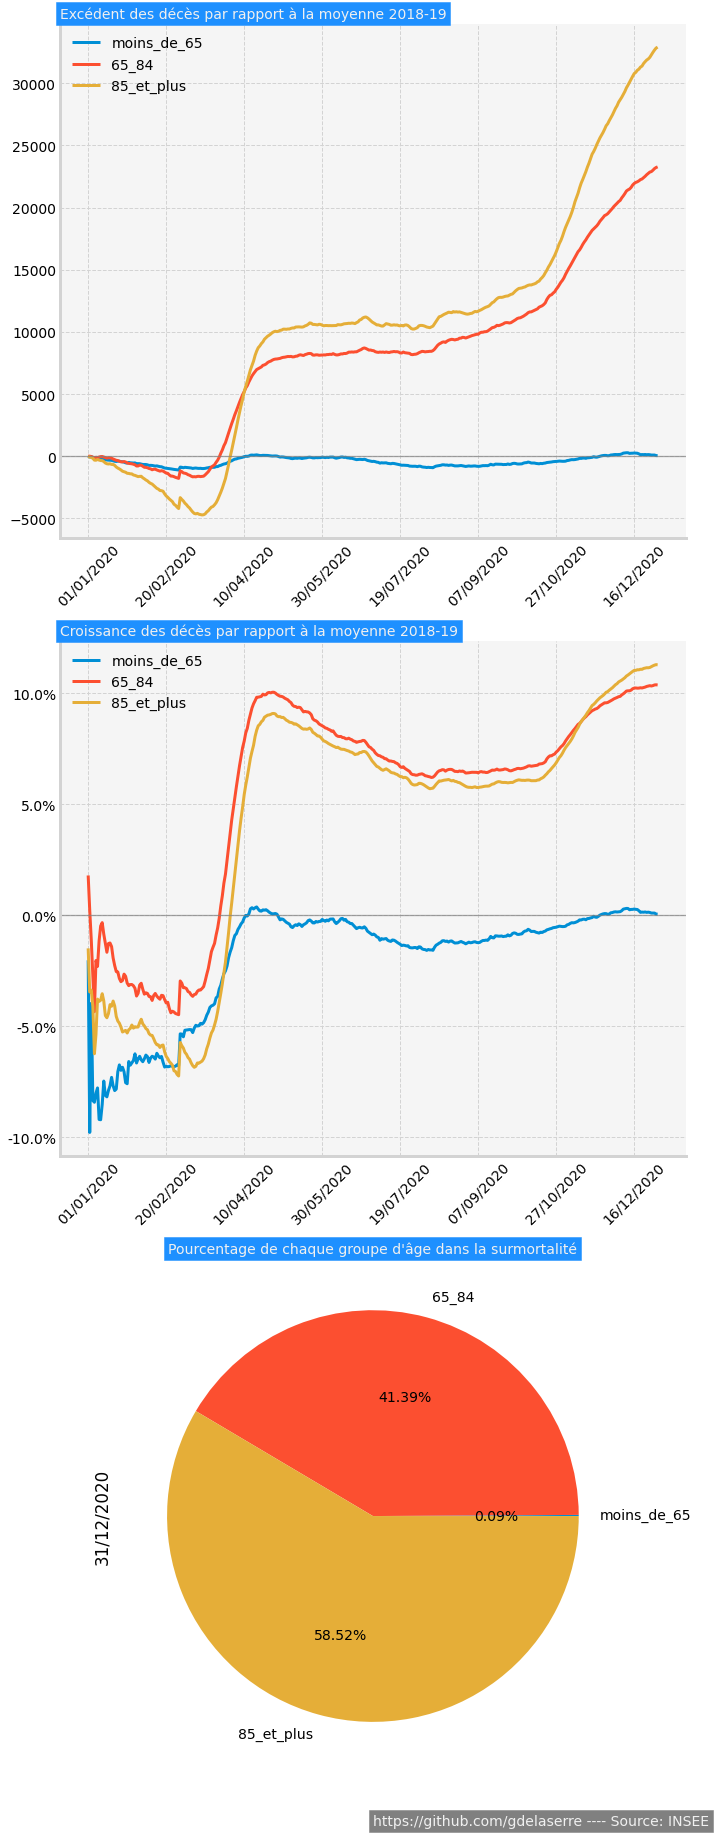

In [ ]:
fig, axes = plt.subplots(3, figsize = (10,30), facecolor='white')
ax1 = clean_data['surmortalite_total'].plot(ax = axes[0], linewidth=3)
ax2 = clean_data['surmortalite_croissance'].plot(ax = axes[1], linewidth=3)
ax3 = clean_data['surmortalite_total'].iloc[-1].plot.pie(autopct = '%.2f%%', textprops={'fontsize': 14})

ax1.set_title('Excédent des décès par rapport à la moyenne 2018-19', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dodgerblue', loc = 'left')
ax2.set_title('Croissance des décès par rapport à la moyenne 2018-19',  fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dodgerblue', loc = 'left')
ax3.set_title ('Pourcentage de chaque groupe d\'âge dans la surmortalité',  fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dodgerblue', loc = 'center')
ax3.text(0,-1.5,'https://github.com/gdelaserre ---- Source: INSEE',fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

for ax in (ax1, ax2):
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left']. set_color('lightgrey')
  ax.spines['bottom']. set_color('lightgrey')
  ax.legend(frameon=False)
  ax.tick_params(axis='x', labelrotation= 45)
  ax.grid(b=True, which='major', color='lightgrey', linestyle='--')
  ax.set_xlabel('')
  ax.axhline(y = 0, color = 'grey', linewidth = 1.3, alpha = .7)
  ax.set_facecolor('whitesmoke')

In [ ]:
# display conclusion in markdown cell

total = clean_data['surmortalite_total'].iloc[-1].sum().astype(int)
perc = 100 * (age_pivot[2020].iloc[-1].sum() / age_pivot['avg_2018_19'].iloc[-1].sum() - 1)
latest_date = clean_data.index[-1]
first_date = clean_data.index[0]
conclusion = '##Entre le {} et le {}, il y avait {} morts en plus par rapport à la moyenne des deux années précédentes sur la même période, soit une augmentation totale de {:.2f}%. '.format(first_date,latest_date,total, perc) 
md(conclusion)


##Entre le 01/01/2020 et le 31/12/2020, il y avait 56216 morts en plus par rapport à la moyenne des deux années précédentes sur la même période, soit une augmentation totale de 9.19%. 

# Comparaison avec la croissance de la mortalité par an depuis 1946

This graph below represents numbers of deaths by year since 1946 in France. 

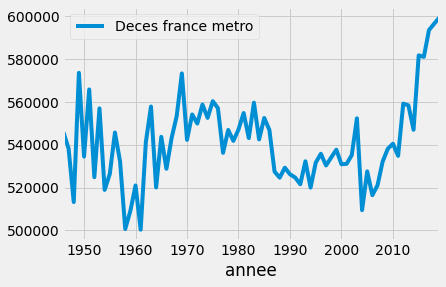

In [ ]:
deces_1946 = pd.read_csv('/content/drive/MyDrive/Insee/original data/deces_1946.csv', delimiter = ',')

plt.style.use('fivethirtyeight')
deces_1946.plot(x = 'annee', y = 'Deces france metro', xlim = (1946, 2019))
plt.show()

In [ ]:
def moyenne(year):
    last_year = year - 1
    two_years_ago = year - 2
    if year > 1947:
      v1 = deces_1946.loc[deces_1946['annee'] == last_year, 'Deces france metro'].iloc[0]
      v2 = deces_1946.loc[deces_1946['annee'] == two_years_ago, 'Deces france metro'].iloc[0]
      v = (v2 + v1) / 2
    else: v = 0
    return v
deces_1946['moyenne'] = deces_1946['annee'].apply(moyenne)
deces_1946['croissance_vs_moyenne_2_annees'] = round(100 * (deces_1946['Deces france metro'] / deces_1946['moyenne'] - 1), 2)
graph_data = deces_1946[2:].drop(columns = ['Deces france metro', 'moyenne'])
graph_data.head(5)

,annee,croissance_vs_moyenne_2_annees
2,1948,-5.32
3,1949,9.11
4,1950,-1.64
5,1951,2.13
6,1952,-4.60


Now let's compare the death count growth rates since 1946 with march to date for 2020. Note that January and February are not included in 2020's data since Covid started effectively in March 2020.   

''

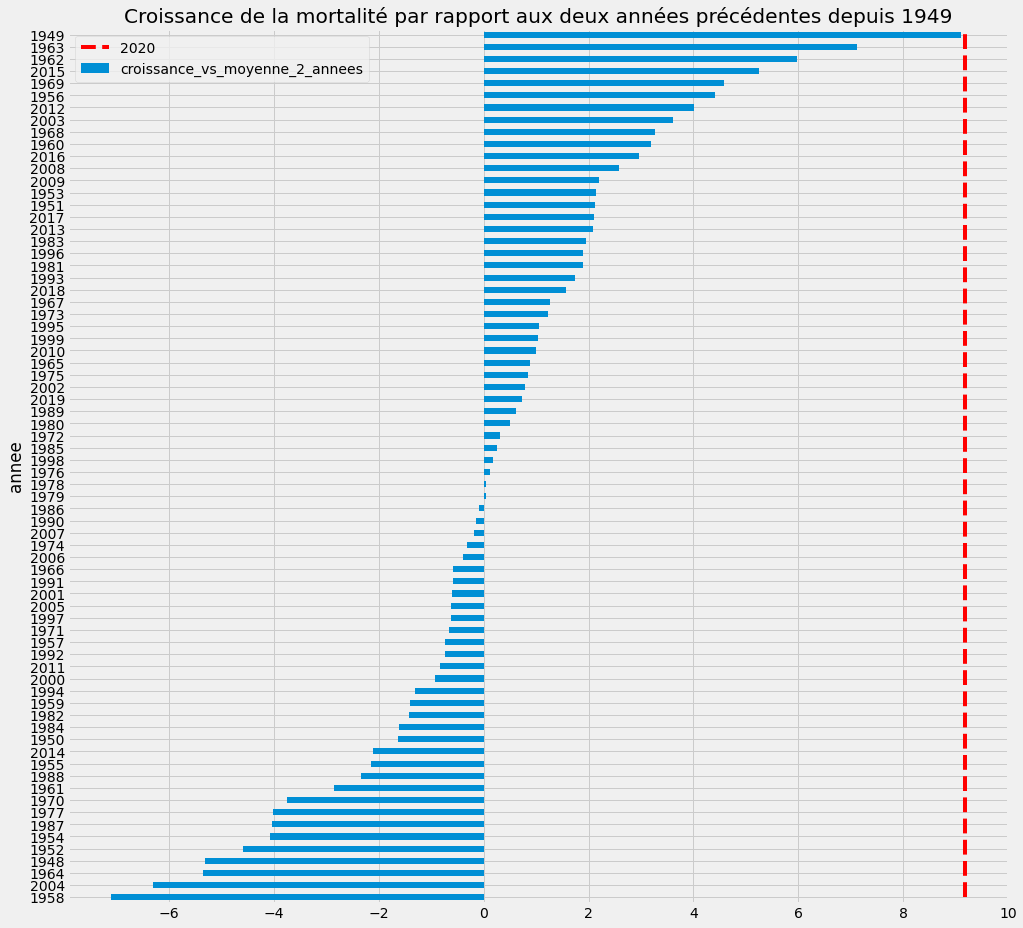

In [ ]:
plt.style.use('fivethirtyeight')
graph_data = graph_data.sort_values(by = 'croissance_vs_moyenne_2_annees', ascending = True)
graph_data.plot(x = 'annee', y = 'croissance_vs_moyenne_2_annees' , kind = 'barh', figsize = (15,15), title = "Croissance de la mortalité par rapport aux deux années précédentes depuis 1949", legend = None)
plt.vlines(x = perc, ymin = 0, ymax = graph_data.shape[0], colors = 'red', linestyles= 'dashed', label = '2020')
plt.legend()
;